In [109]:
import os
import numpy as np
import torch
import torch.nn as nn
import random
import torch.nn.functional as F
from torch import optim
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
from tqdm import tqdm
import numpy as np
%matplotlib inline 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [85]:
dataset_path = 'SCAN-master'
file_name = 'simple_split/size_variations/tasks_train_simple_p16.txt'
test_file_name = 'simple_split/size_variations/tasks_test_simple_p16.txt'
file_path = os.path.join(dataset_path, file_name)
test_file_path = os.path.join(dataset_path, test_file_name)
file_path, test_file_path

('SCAN-master\\simple_split/size_variations/tasks_train_simple_p16.txt',
 'SCAN-master\\simple_split/size_variations/tasks_test_simple_p16.txt')

In [36]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence:
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [101]:
command_le = Lang('command')
action_le = Lang('action')

def dataloader(path):
    with open(path, 'r') as f:
        dataset = f.readlines()

    def preprocess_data(line):
        line = line.strip().split()
        split_index = line.index('OUT:')
        inp = line[1: split_index]
        outp = line[split_index+1:]
        command_le.addSentence(inp)
        action_le.addSentence(outp)
        return [inp, outp]
    
    pairs = list(map(preprocess_data, dataset))
    input_commands, output_actions = np.transpose(pairs).tolist()
    return input_commands, output_actions, pairs

commands, actions, pairs = dataloader(file_path)
test_commands, test_acitons, test_pairs = dataloader(test_file_path)

In [38]:
def indexesFromSentence(le, sentence):
    return [le.word2index[word] for word in sentence]

def tensorFromSentence(le, sentence):
    indexes = indexesFromSentence(le, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1,1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(command_le, pair[0])
    target_tensor = tensorFromSentence(action_le, pair[1])
    return (input_tensor, target_tensor)

In [92]:
MAX_LENGTH = max([len(action) for action in actions]) + 1
MAX_LENGTH

49

In [40]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.dropout = nn.Dropout(p=dropout)
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers=num_layers, dropout=dropout)
        
    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.lstm(output, hidden)
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(self.num_layers, 1, self.hidden_size, device=device)
    
    def initCell(self):
        return torch.zeros(self.num_layers, 1, self.hidden_size, device=device)

In [41]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, num_layers, dropout):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.dropout = nn.Dropout(p=dropout)
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers=num_layers, dropout=dropout)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1) # Could be LogSoftmax
        
    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.lstm(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(self.num_layers, 1, self.hidden_size, device=device)
    
    def initCell(self):
        return torch.zeros(self.num_layers, 1, self.hidden_size, device=device)

In [42]:
teacher_forcing_ratio = 0.5

def train(input_tensor, target_tensor, encoder, decoder, 
          encoder_optimizer, decoder_optimizer, criterion
         ):
    encoder_hidden = encoder.initHidden()
    encoder_cell = encoder.initCell()
    
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    
    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)
    
    loss = 0
    gold_pred = 0
    
    for ei in range(input_length):
        encoder_output, (encoder_hidden, encoder_cell) = encoder(
            input_tensor[ei], (encoder_hidden, encoder_cell))
        
    decoder_input = torch.tensor([[SOS_token]], device=device)
    
    decoder_hidden = encoder_hidden
    decoder_cell = encoder_cell
    # decoder_cell = decoder.initCell()
    
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
    
    if use_teacher_forcing:
        for di in range(target_length):
            decoder_output, (decoder_hidden, decoder_cell) = decoder(
                decoder_input, (decoder_hidden, decoder_cell))
            topv, topi = decoder_output.topk(1)
            pred = topi.squeeze()
            
            if torch.equal(pred, target_tensor[di].squeeze()):
                gold_pred += 1
            
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]
            
            
    else:
        for di in range(target_length):
            decoder_output, (decoder_hidden, decoder_cell) = decoder(
                decoder_input, (decoder_hidden, decoder_cell))
            topv, topi = decoder_output.topk(1)
            pred = topi.squeeze()
            decoder_input = topi.squeeze().detach()
            
            if torch.equal(pred, target_tensor[di].squeeze()):
                gold_pred += 1
            
            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                target_length = di + 1
                break

    loss.backward()
    
    torch.nn.utils.clip_grad_value_(encoder.parameters(), 5.0)
    torch.nn.utils.clip_grad_value_(decoder.parameters(), 5.0)
    encoder_optimizer.step()
    decoder_optimizer.step()
    
    return loss.item() / target_length, gold_pred, target_length

In [43]:
tensorsFromPair(random.choice(pairs))

(tensor([[12],
         [ 3],
         [10],
         [ 8],
         [ 6],
         [12],
         [ 1]], device='cuda:0'),
 tensor([[5],
         [5],
         [4],
         [5],
         [5],
         [4],
         [5],
         [5],
         [4],
         [4],
         [1]], device='cuda:0'))

In [44]:
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [45]:
def showPlot(points, accuracy):
    plt.figure()
    fig, ax = plt.subplots()
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)
    plt.plot(accuracy)
    plt.show()
    
    
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100,
               learning_rate=0.001):
    start = time.time()
    
    plot_losses = []
    plot_accs = []
    print_loss_total = 0
    plot_loss_total = 0
    print_pred_total = 0
    print_label_total = 0
    plot_pred_total = 0
    plot_label_total = 0
    
    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()
    
    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]
        # target_length = target_tensor.size(0)
        
        loss, gold_pred, target_length = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_label_total += target_length
        print_pred_total += gold_pred
        plot_label_total += target_length
        plot_pred_total += gold_pred
        print_loss_total += loss
        plot_loss_total += loss
        
        if iter % print_every == 0:
            print_acc_avg = print_pred_total / print_label_total
            print_loss_avg = print_loss_total / print_every
            print_pred_total = 0
            print_label_total = 0
            print_loss_total = 0
            print('%s (%d %d%%) loss: %.4f acc: %.4f' % (timeSince(start, iter / n_iters),
                                iter, iter / n_iters * 100, print_loss_avg, print_acc_avg))
            
        if iter % plot_every == 0:
            plot_acc_avg = plot_pred_total / plot_label_total
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_accs.append(plot_acc_avg)
            plot_loss_total = 0
            plot_pred_total = 0
            plot_label_total = 0
            
    showPlot(plot_losses, plot_accs)

In [95]:
def evaluate(encoder, decoder, pair, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor, target_tensor = tensorsFromPair(pair)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()
        encoder_cell = encoder.initCell()

        for ei in range(input_length):
            encoder_output, (encoder_hidden, encoder_cell) = encoder(input_tensor[ei],
                                                    (encoder_hidden, encoder_cell))

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden
        decoder_cell = encoder_cell
        
        decoded_words = []

        for di in range(max_length):
            decoder_output, (decoder_hidden, decoder_cell) = decoder(
                decoder_input, (decoder_hidden, decoder_cell))
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(action_le.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words

In [110]:
def evaluate_model(encoder, decoder, test_pairs):
    gold = 0
    total_target = 0
    for pair in tqdm(test_pairs):
        preds = evaluate(encoder, decoder, pair)[:-1]
        target_output = pair[1]
        length = min(len(preds), len(target_output))
        target_length = len(target_output)
        total_target += length
        
        for i in range(length):
            if preds[i] == target_output[i]:
                gold += 1
    return gold / total_target

In [111]:
evaluate_model(encoder1, decoder1, test_pairs)

100%|███████████████████████████████████████████████████████████████████████████| 17565/17565 [02:03<00:00, 142.21it/s]


0.9999085683392035

0m 32s (- 54m 12s) (1000 1%) loss: 1.3601 acc: 0.5374
0m 55s (- 45m 1s) (2000 2%) loss: 0.7826 acc: 0.7250
1m 16s (- 41m 23s) (3000 3%) loss: 0.5323 acc: 0.8174
1m 39s (- 39m 37s) (4000 4%) loss: 0.4138 acc: 0.8489
2m 1s (- 38m 21s) (5000 5%) loss: 0.3445 acc: 0.8749
2m 23s (- 37m 28s) (6000 6%) loss: 0.2635 acc: 0.9020
2m 45s (- 36m 40s) (7000 7%) loss: 0.2271 acc: 0.9131
3m 7s (- 35m 57s) (8000 8%) loss: 0.1949 acc: 0.9208
3m 29s (- 35m 21s) (9000 9%) loss: 0.1639 acc: 0.9334
3m 52s (- 34m 52s) (10000 10%) loss: 0.1369 acc: 0.9450
4m 14s (- 34m 18s) (11000 11%) loss: 0.1120 acc: 0.9531
4m 36s (- 33m 45s) (12000 12%) loss: 0.0992 acc: 0.9597
4m 58s (- 33m 19s) (13000 13%) loss: 0.0880 acc: 0.9646
5m 20s (- 32m 49s) (14000 14%) loss: 0.0806 acc: 0.9681
5m 42s (- 32m 22s) (15000 15%) loss: 0.0701 acc: 0.9691
6m 5s (- 31m 57s) (16000 16%) loss: 0.0575 acc: 0.9753
6m 27s (- 31m 31s) (17000 17%) loss: 0.0541 acc: 0.9752
6m 49s (- 31m 6s) (18000 18%) loss: 0.0514 acc: 0.9786
7m 11s (- 30m 3

<Figure size 432x288 with 0 Axes>

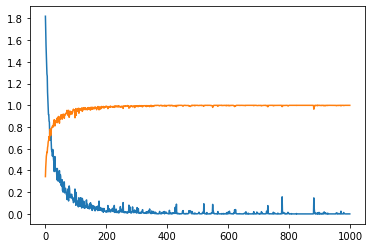

In [47]:
hidden_size = 200
input_size = command_le.n_words
output_size = action_le.n_words
encoder1 = EncoderRNN(input_size, hidden_size, num_layers=2, dropout=0).to(device)
decoder1 = DecoderRNN(hidden_size, output_size, num_layers=2, dropout=0).to(device)

trainIters(encoder1, decoder1, 100000, print_every=1000)

In [60]:
input_size, output_size

(15, 8)

In [93]:
evaluate_model(encoder1, decoder1, test_pairs)

[['walk', 'opposite', 'right', 'thrice', 'and', 'run', 'twice'], ['I_TURN_RIGHT', 'I_TURN_RIGHT', 'I_WALK', 'I_TURN_RIGHT', 'I_TURN_RIGHT', 'I_WALK', 'I_TURN_RIGHT', 'I_TURN_RIGHT', 'I_WALK', 'I_RUN', 'I_RUN', '<EOS>']]


KeyError: '<EOS>'

In [61]:
pairs[12]

[['turn', 'opposite', 'left', 'thrice', 'after', 'walk', 'around', 'left'],
 ['I_TURN_LEFT',
  'I_WALK',
  'I_TURN_LEFT',
  'I_WALK',
  'I_TURN_LEFT',
  'I_WALK',
  'I_TURN_LEFT',
  'I_WALK',
  'I_TURN_LEFT',
  'I_TURN_LEFT',
  'I_TURN_LEFT',
  'I_TURN_LEFT',
  'I_TURN_LEFT',
  'I_TURN_LEFT']]

In [ ]:
class EncoderGRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout):
        super(EncoderGRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.dropout = nn.Dropout(p=dropout)
        self.gru = nn.GRU(hidden_size, hidden_size, num_layers=num_layers, dropout=dropout)
        
    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(self.num_layers, 1, self.hidden_size, device=device)

In [ ]:
class AttnDecoderGRU(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.5):
        super(AttnDecoderGRU, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.tanh = nn.Tanh()
        self.Ua = nn.Linear(self.hidden_size, self.hidden_size)
        self.Wa = nn.Linear(self.hidden_size, self.hidden_size)
        self.va = torch.tensor(torch.randn(1, hidden_size), requires_grad=True).cuda()
        
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size * 2, self.output_size)
        
    def forward(self, input, hidden, encoder_hiddens):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)
        
        encoder_hiddens = encoder_hiddens.unsqueeze(1)
        attn_weights = F.softmax(torch.inner(
            self.va, self.tanh(self.Ua(encoder_hiddens) + self.Wa(hidden))), dim=1)
        
        context = torch.sum(
            torch.mul(attn_weights, encoder_hiddens.squeeze()), dim=1)

        output = torch.cat((embedded[0], context), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        
        cat_output = torch.cat((context, hidden[0]), 1)
        output = F.log_softmax(self.out(cat_output), dim=1)

        return output, hidden, attn_weights
    
    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [ ]:
pairtensor = tensorsFromPair(pairs[0])
input_tensor = pairtensor[0]
target_tensor = pairtensor[1]
input_size = len(command_le.classes_)
output_size = len(action_le.classes_)
hidden_size = 200
hidden = torch.zeros(1,1,hidden_size, device=device)

embedding = nn.Embedding(input_size, hidden_size).cuda()
gru = nn.GRU(hidden_size, hidden_size).cuda()
embedded = embedding(input_tensor)
output = embedded
output, hidden = gru(output, hidden)

In [ ]:
output_size

In [ ]:
hiddens = torch.randn(9,1,200).cuda()
hidden = torch.randn(1,1,200).cuda()
tanh = nn.Tanh()
Ua = nn.Linear(200, 200).cuda()
Wa = nn.Linear(200, 200).cuda()
va = torch.tensor(torch.randn(1, 200)).cuda()
#weights = torch.inner(Ua, hiddens).squeeze() + torch.inner(Wa, hidden).squeeze()
weights = F.softmax(torch.inner(va, tanh(Ua(hiddens)+Wa(hidden))), dim=1)

In [ ]:
context = torch.sum(
            torch.mul(weights, hiddens.squeeze()), dim=1)
context.shape

In [ ]:
teacher_forcing_ratio = 0.5

def train2(input_tensor, target_tensor, encoder, decoder, 
          encoder_optimizer, decoder_optimizer, criterion
          ):
    encoder_hidden = encoder.initHidden()
    
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    
    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)
    
    encoder_hiddens = torch.zeros(input_length, encoder.hidden_size, device=device)
    
    loss = 0
    gold_pred = 0
    
    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_hiddens[ei] = encoder_hidden[0, 0]
        
    decoder_input = torch.tensor([[SOS_token]], device=device)
    
    decoder_hidden = encoder_hidden
    
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
    
    if use_teacher_forcing:
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_hiddens)
            topv, topi = decoder_output.topk(1)
            pred = topi.squeeze()
            
            if torch.equal(pred, target_tensor[di].squeeze()):
                gold_pred += 1
            
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]
            
    else:
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_hiddens)
            topv, topi = decoder_output.topk(1)
            pred = topi.squeeze()
            decoder_input = topi.squeeze().detach()
            
            if torch.equal(pred, target_tensor[di].squeeze()):
                gold_pred += 1
            
            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                target_length = di + 1
                break

    loss.backward()
    
    torch.nn.utils.clip_grad_norm_(encoder.parameters(), max_norm=5.0)
    torch.nn.utils.clip_grad_norm_(decoder.parameters(), max_norm=5.0)
    encoder_optimizer.step()
    decoder_optimizer.step()
    
    return loss.item() / target_length, gold_pred, target_length

In [ ]:
def trainIters2(encoder, decoder, n_iters, print_every=1000, plot_every=100,
               learning_rate=0.001):
    start = time.time()
    
    plot_losses = []
    plot_accs = []
    print_loss_total = 0
    plot_loss_total = 0
    print_pred_total = 0
    print_label_total = 0
    plot_pred_total = 0
    plot_label_total = 0
    
    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()
    
    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]
        # target_length = target_tensor.size(0)
        
        loss, gold_pred, target_length = train2(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_label_total += target_length
        print_pred_total += gold_pred
        plot_label_total += target_length
        plot_pred_total += gold_pred
        print_loss_total += loss
        plot_loss_total += loss
        
        if iter % print_every == 0:
            print_acc_avg = print_pred_total / print_label_total
            print_loss_avg = print_loss_total / print_every
            print_pred_total = 0
            print_label_total = 0
            print_loss_total = 0
            print('%s (%d %d%%) loss: %.4f acc: %.4f' % (timeSince(start, iter / n_iters),
                                iter, iter / n_iters * 100, print_loss_avg, print_acc_avg))
            
        if iter % plot_every == 0:
            plot_acc_avg = plot_pred_total / plot_label_total
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_accs.append(plot_acc_avg)
            plot_loss_total = 0
            plot_pred_total = 0
            plot_label_total = 0
            
    showPlot(plot_losses, plot_accs)
    return encoder, decoder

In [ ]:
hidden_size = 50
input_size = len(command_le.classes_)
output_size = len(action_le.classes_)
encoder1 = EncoderGRU(input_size, hidden_size, num_layers=1, dropout=0.5).to(device)
decoder1 = AttnDecoderGRU(hidden_size, output_size, dropout_p=0.5).to(device)

encoder1, decoder1 = trainIters2(encoder1, decoder1, 10000, print_every=1000)

In [ ]:
def evaluate(encoder, decoder, pair, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor, target_tensor = tensorsFromPair(pair)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()
        
        encoder_hiddens = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
            
            encoder_hiddens[ei] = encoder_hidden[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden
        
        decoded_words = []

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_hiddens)
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(action_le.transform(topi.item()))

            decoder_input = topi.squeeze().detach()

        return decoded_words

In [ ]:
evaluate(encoder1, decoder1, pairs[2122])

In [ ]:
input_tensor, target_tensor = tensorsFromPair(pairs[123])
input_length = input_tensor.size()[0]
encoder_hidden = encoder1.initHidden()

encoder_hiddens = torch.zeros(10, encoder1.hidden_size, device=device)

for ei in range(input_length):
    encoder_output, encoder_hidden = encoder1(input_tensor[ei], encoder_hidden)

    encoder_hiddens[ei] = encoder_hidden[0, 0]

In [ ]:
decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

decoder_hidden = encoder_hidden

decoded_words = []

In [ ]:
decoder_output, decoder_hidden, decoder_attention = decoder1(
                decoder_input, decoder_hidden, encoder_hiddens)


In [ ]:
topv, topi = decoder_output.data.topk(1)
topv, topi, decoder_output